# 1. Setup

The Corpus of Linguistic Acceptability (CoLA) dataset

It's a set of sentences labeled as grammatically correct or incorrect.

The dataset can be found on GitHub in this repo: https://nyu-mll.github.io/CoLA/

## 1.1. Using Colab GPU for Training


In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

In [ ]:
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.2. Installing the Hugging Face Library


In [ ]:
!pip install transformers

     |████████████████████████████████| 389kB 3.4MB/s 
     |████████████████████████████████| 860kB 44.9MB/s 
     |████████████████████████████████| 696kB 43.6MB/s 
     |████████████████████████████████| 1.0MB 34.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=224727a36ca806911eba978b9150331daecc6deae8bddf8f171029d137b31c2c
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


# 2. Loading CoLA Dataset


## 2.1. Download & Extract

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=a6fdb3b6384387a047c5a76d75d01ecde89a1735ca0a70202174f2064688424c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import wget
import os

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


## 2.2. Parse

In [ ]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
1942,r-67,0,*,Every student who ever goes to Europe ever has...
7611,sks13,1,NaN,Is there anything to do today?
7685,sks13,0,*,John convinced the rice to be cooked by Bill.
3923,ks08,1,NaN,The birds devour the worm.
722,bc01,0,*,Home was gone by John.
130,cj99,0,*,"The more John eats, the tighter keep your mout..."
5387,b_73,0,*,She has problem enough as it is.
4566,ks08,0,*,The roof is leaked.
4480,ks08,0,*,John did not leaving here.
5548,b_73,1,NaN,Mary has more than two friends.


In [ ]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
1651,Here's a knife for you to say was on the table.,0
2904,I detached the handle and the box.,0
7409,They are readable of the paper.,0
3116,Cynthia lunched peaches.,0
1155,I insist on seeing through all the students wh...,0


In [ ]:
sentences = df.sentence.values
labels = df.label.values

# 3. Tokenization & Input Formatting


## 3.1. BERT Tokenizer

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
print(' Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


## 3.2. Sentences to IDs

In [ ]:
input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,
                        add_special_tokens = True, # '[CLS]' and '[SEP]'
                   )

    input_ids.append(encoded_sent)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


## 3.3. Padding & Truncating

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  47


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.


Using TensorFlow backend.


## 3.4. Attention Masks

In [ ]:
attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]

    attention_masks.append(att_mask)

## 3.5. Training & Validation Split


In [ ]:
from sklearn.model_selection import train_test_split

# 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

## 3.6. Converting to PyTorch Data Types

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# 4. Training Classification Model

## 4.1. BertForSequenceClassification

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

## 4.2. Optimizer & Learning Rate Scheduler

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:11.
  Batch    80  of    241.    Elapsed: 0:00:21.
  Batch   120  of    241.    Elapsed: 0:00:31.
  Batch   160  of    241.    Elapsed: 0:00:42.
  Batch   200  of    241.    Elapsed: 0:00:52.
  Batch   240  of    241.    Elapsed: 0:01:03.

  Average training loss: 0.50
  Training epcoh took: 0:01:03

Running Validation...
  Accuracy: 0.79
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:11.
  Batch    80  of    241.    Elapsed: 0:00:21.
  Batch   120  of    241.    Elapsed: 0:00:32.
  Batch   160  of    241.    Elapsed: 0:00:42.
  Batch   200  of    241.    Elapsed: 0:00:52.
  Batch   240  of    241.    Elapsed: 0:01:03.

  Average training loss: 0.32
  Training epcoh took: 0:01:03

Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:11.
  

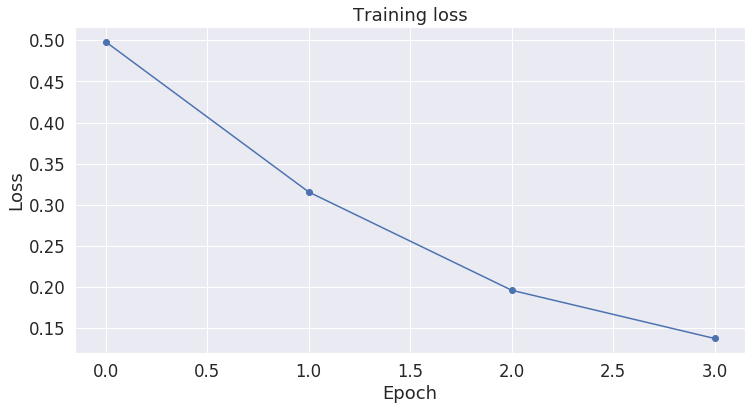

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()